<br />
<p align="center">
  <img src="../images/dtlogo.png" alt="Logo" width="111" height="100">

  <h1 align="center">Object detection</h1>
</p>



### Object Detection

Machine-learned object detection models can be extremely useful. They are faster and often more reliable than most traditional computer vision models. Aditionnally, we can use pretrained model weights to cut down immensely on training time.

Here's an example of what an object detector might output:



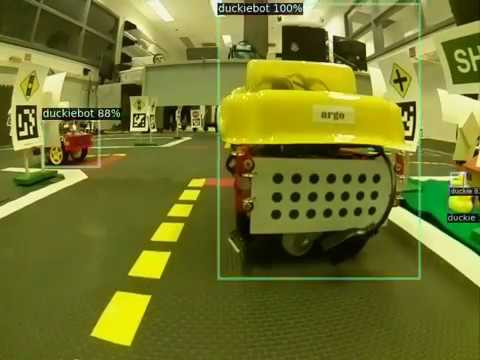

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('3jD02dxL6gg', width=800, height=500)


In this exercise, you will create your own Duckietown object detection dataset. You will learn about the general structure such a dataset should follow. You will train an object detection model on said dataset. Finally, you will integrate said model into a ROS node, so that your duckiebot knows how to recognize duckie pedestrians (and thus avoid them).

### Steps:

1. Setup  
2. Investigation
3. Data collection
4. Training
5. Integration



### 1. Setup

First, we need some global variables. These allow you to change the directory where we save of of the data you will need. You can also change the image size to reflect what your final model uses, but you can worry about that later.

In [2]:
DATASET_DIR="./dataset"
IMAGE_SIZE = 416

import subprocess

def run(input, exception_on_failure=False):
    try:
        program_output = subprocess.check_output(f"{input}", shell=True, universal_newlines=True, stderr=subprocess.STDOUT)
    except Exception as e:
        if exception_on_failure:
            raise e
        program_output = e.output

    return program_output

def runp(input, exception_on_failure=False):
    print(run(input, exception_on_failure))
    
import contextlib
import os

@contextlib.contextmanager
def makedirs(name):
    try:
        os.makedirs(name)
    except:
        pass
    yield None

While you will build your own dataset with simulated images in part 2, it would be unreasonable to ask you to build your own dataset of real images. Run the cell bellow to download a dataset of labelled real images.

In [3]:
runp(f"rm -rf {DATASET_DIR}")
runp(f"mkdir {DATASET_DIR}")
# use <!> to have a download indicator
!wget -O duckietown_object_detection_dataset.zip https://www.dropbox.com/s/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip?dl=0
runp(f"unzip duckietown_object_detection_dataset.zip -d {DATASET_DIR}")
runp(f"mv {DATASET_DIR}/duckietown\ object\ detection\ dataset/* {DATASET_DIR} && rm -rf {DATASET_DIR}/duckietown\ object\ detection\ dataset")
runp(f"rm -rf duckietown_object_detection_dataset.zip")



--2021-05-18 14:14:03--  https://www.dropbox.com/s/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.11.18, 2620:100:6050:18::a27d:b12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.11.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip [following]
--2021-05-18 14:14:08--  https://www.dropbox.com/s/raw/bpd535fzmj1pz5w/duckietown%20object%20detection%20dataset-20201129T162330Z-001.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceaaa4dcc856467c3fcf128cf97.dl.dropboxusercontent.com/cd/0/inline/BOswW8xpfX2eoxeLplu_D4SF5saiFpy7NwfrAbKOdNakQP-0DJnpx-uFdOUq8TTgfp0MYnDmgPZxH6V-dh-uEy3f7ZapnECGFerOntapBsedIEeN5DP_FWZoUPTKBmZwrpz_Yg5Wnpmfvtvq5g5QAf1p/file# [following]
--2021-05-18 14:14:

These real images are not the right size. Run the cell bellow to resize them (and resize the associated bounding boxes accordingly).

In [11]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm

with open(f"{DATASET_DIR}/annotation/final_anns.json") as anns:
    annotations = json.load(anns)

npz_index = 0
while os.path.exists(f"{DATASET_DIR}/{npz_index}.npz"):
    npz_index += 1

def save_img(img, boxes, classes):
    global npz_index
    cv2.imwrite(f"{DATASET_DIR}/real_{npz_index}.jpg", img)
    with open(f"{DATASET_DIR}/real_{npz_index}.txt", "w") as f:
        for i in range(len(boxes)):
            f.write(f"{classes[i]} "+" ".join(map(str,boxes[i]))+"\n")
    npz_index += 1

for filename in tqdm(os.listdir(f"{DATASET_DIR}/frames")):
    img = cv2.imread(f"{DATASET_DIR}/frames/{filename}")

    orig_y, orig_x = img.shape[0], img.shape[1]
    scale_y, scale_x = IMAGE_SIZE/orig_y, IMAGE_SIZE/orig_x

    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    boxes = []
    classes = []

    if filename not in annotations:
        continue

    for detection in annotations[filename]:
        box = detection["bbox"]
        label = detection["cat_name"]

        if label not in ["duckie", "cone"]:
            continue

        orig_x_min, orig_y_min, orig_w, orig_h = box

        x_min = int(np.round(orig_x_min * scale_x))
        y_min = int(np.round(orig_y_min * scale_y))
        x_max = x_min + int(np.round(orig_w * scale_x))
        y_max = y_min + int(np.round(orig_h * scale_y))

        boxes.append([x_min, y_min, x_max, y_max])
        classes.append(1 if label == "duckie" else 2)

    if len(boxes) == 0:
        continue

    #make boxes to xywh format:
    def xminyminxmaxymax2xywfnormalized(box, image_size):
        xmin, ymin, xmax, ymax = np.array(box, dtype=np.float64)
        center_x = (xmin+xmax)/2
        center_y = (ymin+ymax)/2
        width = xmax-xmin
        height = ymax-ymin

        normalized = np.array([center_x, center_y, width, height])/image_size
        return np.round(normalized, 5)
    boxes = np.array([xminyminxmaxymax2xywfnormalized(box, IMAGE_SIZE) for box in boxes])
    classes = np.array(classes)-1
    
    save_img(img, boxes, classes)


100%|██████████| 1963/1963 [00:13<00:00, 146.61it/s]


And finally, you need to install gym-duckietown. Follow the instructions listed here: https://github.com/duckietown/gym-duckietown

We recommend doing so in a virtual environment (https://docs.python.org/3/library/venv.html), but that is up to you.

Once that's done, you're all set! We'll explain what all the code above was for later in this notebook.

### 2. Investigation

What does an object detection dataset look like? Clearly, the specifics will depend on the convention used by specific models, but the general idea is intuitive:

- We need an image
- This image might have many bounding boxes in it, so we need some sort of list of coordinates
- These bounding boxes must be associated with a class

How are the bounding boxes defined?

![image of a bounding box](../images/bbox.png)
\[Note: if you are not colorblind, you may ignore the scribbles under the colored indications for widths and heights\]

Some conventions use `x_min y_min width height`, whereas others use `x_min y_min x_max y_max`, and others use `x_center y_center width height`. In this exercise, the model we recommend ([YoloV5](https://github.com/Velythyl/yolov5)) uses `x_center y_center width height`.

And how do we actually obtain said bounding boxes? Clearly, in real-life applications, you would need to label a dataset of images by hand. But if you have access to a simulator that is able to segment images, you could obtain the bounding boxes directly from the segmented images. 

If you take a look at Pytorch's object detection [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html), that is similar to what they do. While their images were segmented by hand, the tutorial uses the same technique that we will use here to obtain the bounding boxes. Their images look like this:

![image with bounding boxes](../images/FudanPed.png)
<p align="center">\[Source: https://www.cis.upenn.edu/~jshi/ped_html/\]</p>

And they simply calculate the min and max x and y coordinates of the segmented objects to obtain the bounding box.

We will use the segmented mode in the Duckietown simulator to compute the bounding boxes of non-segmented images.

#### What we want to detect

The goal of this exercise is to make Duckietown safer: we want to be able to detect duckie pedestrians on the road and avoid squishing them. We also want to detect trucks, busses, and cones. Here is the complete list, along with their corresponding IDs:

0. Duckie
1. Cone
2. Truck
3. Bus


### 3. Data collection


#### Format

Edit the [../utils/data_collection.py](../utils/data_collection.py) script so that running it produces a dataset of normal simulator images and their annotations.

You will need to run the script locally, outside of a jupyter notebook and outside of Docker. The reason is simple: you will need to create and fine-tune OpenCV masks in order to filter out everything except the objects that we are interested in. Doing so requires access to your computer's rendering server.

Of course, your dataset's format depends heavily on your model. If you want to use the [YoloV5](https://github.com/Velythyl/yolov5) model that we suggest, you should colosely follow their [guide on how to train using custom data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data).

To simplify your task, we have already written a `duckietown.yaml` file that will enable YoloV5 to understand your dataset. You will need to save your images and their bounding box data in this very specific way:

![image of dataset save format](../images/dataset_format.png)

In the parent directory (named `duckietown_dataset`), you must place two subdirectories: `train` and `val` (for now, ignore `val`, or go read "Combining with the real dataset & Validation"). Inside `train` and `val`, there must again be two subdirectories `images` and `labels`. Inside `images`, you must place your images, and inside `labels`, you must place the images' bounding box data. Notice that the label files use the same name as their corresponding image files, save for the extension. In other words, the data for `0.jpg` can be found in `0.txt`.

The format for the label files is fairly simple. For each bounding box in the corresponding image, write a row of the form `class x_center y_center width height`. Keep in mind that the pixel data must be 0-to-1 normalized (i.e., you can calculate the usual `x_center y_center width height` in pixel space and divide by the image's size). For example,

    0 0.5 0.5 0.2 0.2
    1 0.60 0.70 0.4 0.2

this file says "there is a duckie (class 0) centered in the image, whose width and height are 20% of the image's own. There is also a cone whose center is at 60% of the image's maximal x values and 70% of the image's maximal y value, and its width is 40% of the image's own while its height is 20%."

It is recommended that you read the guide posted on YoloV5's GitHub: [guide on how to train using custom data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data).

#### Generating data

Here is some pseudocode, to get you started:

1. Take the segmented image

![image with bounding boxes](../images/normal.png)

2. For each color in the interesting colors (so the colors for duckies, trucks, busses, and cones):
    1. Remove all other colors

![image with bounding boxes](../images/normal_duckie.png)

    2. Identify each instance of the class (there might be more than one in an image. You can take inspiration from this code: https://stackoverflow.com/a/60068297/11296012
    3. Save these bounding boxes to some kind of list

3. Save the non-segmented version of the image, and write its bounding boxes+their classes to a corresponding txt file. Of coure, if you don't plan on using the YoloV5 model that we suggest, you will need to change this format accordingly.

#### Combining with the real dataset & Validation

Notice that the images that you generated here all come from the simulator. These images are only useful in simulation: real duckies, trucks, busses, and cones look fairly different! Luckily, during Step 1 of this exercise, you downloaded a dataset of real annotated images. 

You should be able to view them locally in the `real_dataset` directory.

You must now combine the real dataset with your dataset (the "simulated dataset"). But there is one extra worry: validation.

When training supervised learning models, one must worry about overfitting. You should always keep *some* of your dataset *out* of your training data. This way, you can verify that your model does not overfit to your dataset by *validating* it on the data you left out. 

During this step, while integrating the real dataset, you should worry about the validation dataset. Perhaps you should split the real dataset (80% for training data, 20% for validation? 70/30? 50/50?), and generate new simulated images for validation too!

In [1]:
import gym_duckietown

DEBUG:commons:version: 6.1.7 *
INFO:typing:version: 6.1.8
DEBUG:duckietown_world:duckietown-world version 6.2.20 path /usr/local/lib/python3.8/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.0.41 path /usr/local/lib/python3.8/dist-packages
INFO:nodes:version 6.1.1 path /usr/local/lib/python3.8/dist-packages pyparsing 2.4.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.12 path /usr/local/lib/python3.8/dist-packages



In [1]:
%run ../utils/data_collection.py

DEBUG:commons:version: 6.1.7 *
INFO:typing:version: 6.1.8
DEBUG:duckietown_world:duckietown-world version 6.2.18 path /home/liam/dt-env-developer/venv/lib/python3.8/site-packages
INFO:geometry:version: 2.0.5
DEBUG:aido_schemas:aido-protocols version 6.0.41 path /home/liam/dt-env-developer/venv/lib/python3.8/site-packages
INFO:nodes:version 6.1.1 path /home/liam/dt-env-developer/venv/lib/python3.8/site-packages pyparsing 2.4.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.12 path /home/liam/dt-env-developer/venv/lib/python3.8/site-packages

INFO:gym-duckietown:Information about the graphics card:
 pyglet_version: 1.5.0
    information: dict[4]
                 │ vendor: Mesa/X.org
                 │ renderer: llvmpipe (LLVM 11.0.0, 256 bits)
                 │ version: 3.1 Mesa 20.2.6
                 │ shading-language-version: 1.40
  nvidia_around: True
INFO:duckietown_world: data: /home/liam/dt-env-developer/venv/lib/python3.8/site-packages/duckietown_world/data
DEBUG:gym-duckietow

INFO:gym-duckietown:Starting at [1.2734204  0.         1.28073076] 1.5358520809728624
INFO:gym-duckietown:using DuckietownEnv
INFO:gym-duckietown:Information about the graphics card:
 pyglet_version: 1.5.0
    information: dict[4]
                 │ vendor: Mesa/X.org
                 │ renderer: llvmpipe (LLVM 11.0.0, 256 bits)
                 │ version: 3.1 Mesa 20.2.6
                 │ shading-language-version: 1.40
  nvidia_around: True
DEBUG:gym-duckietown:loading map file "/home/liam/dt-env-developer/venv/lib/python3.8/site-packages/duckietown_world/data/gd1/maps/ETH_large_loop.yaml"
INFO:gym-duckietown:done
INFO:gym-duckietown: light_pos: [0.0, 3.0, 0.0, 1.0]
   ambient: instance of ndarray: array([0.25, 0.25, 0.25, 1.  ])
   diffuse: instance of ndarray: array([0.35, 0.35, 0.35, 1.  ])
  specular: instance of ndarray: array([0., 0., 0., 1.])
INFO:gym-duckietown:Starting at [1.91417996 0.         1.36399411] 1.4233547853358555
INFO:gym-duckietown:using DuckietownEnv
INFO:gym-d

INFO:gym-duckietown:done
INFO:gym-duckietown: light_pos: [0.0, 3.0, 0.0, 1.0]
   ambient: instance of ndarray: array([0.25, 0.25, 0.25, 1.  ])
   diffuse: instance of ndarray: array([0.35, 0.35, 0.35, 1.  ])
  specular: instance of ndarray: array([0., 0., 0., 1.])
DEBUG:gym-duckietown:No tile found at [ 1.01418969  0.         -0.02261545] (1, -1)
DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [1.06464353 0.         0.0829469 ]
DEBUG:gym-duckietown:l_pos: [0.9766749  0.         0.12499176]
DEBUG:gym-duckietown:r_pos: [1.15261215 0.         0.04090203]
DEBUG:gym-duckietown:f_pos: [ 1.01418969  0.         -0.02261545]
INFO:gym-duckietown:Starting at [0.66375447 0.         0.36140483] 0.8699730466102168
INFO:gym-duckietown:using DuckietownEnv
INFO:gym-duckietown:Information about the graphics card:
 pyglet_version: 1.5.0
    information: dict[4]
                 │ vendor: Mesa/X.org
         

INFO:gym-duckietown:using DuckietownEnv
INFO:gym-duckietown:Information about the graphics card:
 pyglet_version: 1.5.0
    information: dict[4]
                 │ vendor: Mesa/X.org
                 │ renderer: llvmpipe (LLVM 11.0.0, 256 bits)
                 │ version: 3.1 Mesa 20.2.6
                 │ shading-language-version: 1.40
  nvidia_around: True
DEBUG:gym-duckietown:loading map file "/home/liam/dt-env-developer/venv/lib/python3.8/site-packages/duckietown_world/data/gd1/maps/TTIC_ripltown.yaml"
INFO:gym-duckietown:done
INFO:gym-duckietown: light_pos: [0.0, 3.0, 0.0, 1.0]
   ambient: instance of ndarray: array([0.25, 0.25, 0.25, 1.  ])
   diffuse: instance of ndarray: array([0.35, 0.35, 0.35, 1.  ])
  specular: instance of ndarray: array([0., 0., 0., 1.])
INFO:gym-duckietown:Starting at [2.11927154 0.         2.6694824 ] 3.5535262528433496
INFO:gym-duckietown:using DuckietownEnv
INFO:gym-duckietown: light_pos: [0.0, 3.0, 0.0, 1.0]
   ambient: instance of ndarray: array([0.25

DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [0.81289147 0.         0.57283291]
DEBUG:gym-duckietown:l_pos: [0.81213784 0.         0.67033   ]
DEBUG:gym-duckietown:r_pos: [0.8136451  0.         0.47533582]
DEBUG:gym-duckietown:f_pos: [0.69589497 0.         0.57192855]
DEBUG:gym-duckietown:[1.03961781 0.         0.65280067] corresponds to tile at (1, 1) which is not drivable: {'coords': (1, 1), 'kind': 'grass', 'angle': 1, 'drivable': False, 'texture': <gym_duckietown.graphics.Texture object at 0x7f7b18e25a00>, 'color': array([1, 1, 1, 1])}
DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [1.06694175 0.         0.53903599]
DEBUG:gym-duckietown:l_pos: [1.16174565 0.         0.56180594]
DEBUG:gym-duckietown:r_pos: [0.97213785 0.         0.51626604]
DEBUG:gym-duckietown:f_pos: [1.03961781 0.    

DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [1.20783039 0.         1.01016244]
DEBUG:gym-duckietown:l_pos: [1.29560172 0.         1.05261763]
DEBUG:gym-duckietown:r_pos: [1.12005906 0.         0.96770725]
DEBUG:gym-duckietown:f_pos: [1.15688416 0.         1.11548804]
DEBUG:gym-duckietown:[1.12692514 0.         0.67084634] corresponds to tile at (1, 1) which is not drivable: {'coords': (1, 1), 'kind': 'grass', 'angle': 1, 'drivable': False, 'texture': <gym_duckietown.graphics.Texture object at 0x7f7b18edbee0>, 'color': array([1, 1, 1, 1])}
DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [1.22338452 0.         0.68505329]
DEBUG:gym-duckietown:l_pos: [1.12692514 0.         0.67084634]
DEBUG:gym-duckietown:r_pos: [1.31984391 0.         0.69926025]
DEBUG:gym-duckietown:f_pos: [1.24043287 0.    

KeyboardInterrupt: 

### 4. Training

Training the model requires a GPU. If you have one, you can simply `git clone https://github.com/Velythyl/yolov5.git -b dt-obj-det` and call `python3 train.py --img 416 --batch 16 --epochs 100 --data duckietown.yaml --weights yolov5s.pt`. For reference, on a gtx1080ti and a ryzen 3700x, training took us about 20 minutes.

If you do not have a GPU, you can use google Colab. You can import the colab notebook called `dt_obj_det.ipynb`. You will also need to upload your dataset to your Google Drive. For reference, on google colab, training took us about 1h. Don't forget to change the runtime type to GPU-accelerated!

### 5. Integration

Finally, you need to integrate your model with ROS. You must edit the object detection node found in `src/object_detection/src`.

#### If you don't have a Jetson Nano Duckiebot

You can run this exercise locally. This will run your code as a pytorch model

#### If you have a Jetson Nano Duckiebot

You can run this exercise on your Duckiebot. This will convert your model to a TensorRT model, and run it your Jetson Nano's GPU.

#### What you have to do

In both cases, you need to edit the ROS node to decide how you will use the detections. Should you call your model on every image from your camera? Only once every 4-5 frames, to preserve your CPU? You might also want to change your robot's behaviour depending on the size of the detection. If it is small, the object is probably far away, so there's no need to stop.